### Antoine EDY
# Natural Language Processing (COMM061) - Coursework

In [1]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import load_dataset
import torch
import nltk
from torch.utils.tensorboard import SummaryWriter

In [2]:
dataset = load_dataset("surrey-nlp/PLOD-CW")

In [3]:
TEXT2ID = {
    "B-O": 0,
    "B-AC": 1,
    "PAD": 2,
    "B-LF": 3,
    "I-LF": 4,
}
ID2TEXT = {v: k for k, v in TEXT2ID.items()}

print(f"TEXT2ID: {TEXT2ID}\nID2TEXT: {ID2TEXT}\n")

def preprocess(df):
    df = df.drop(columns=['pos_tags'])
    df = df.rename(columns={"ner_tags": "labels"})
    df["ids"] = df["labels"].apply(lambda x: [TEXT2ID[i] for i in x])
    df["sentences"] = df["tokens"].apply(lambda x: " ".join(x))

    return df


train_dataset = preprocess(pd.DataFrame(dataset['train']))
test_dataset = preprocess(pd.DataFrame(dataset['test']))
val_dataset = preprocess(pd.DataFrame(dataset['validation']))

train_dataset.info()


# Here the exploration to add at the end of the work.

TEXT2ID: {'B-O': 0, 'B-AC': 1, 'PAD': 2, 'B-LF': 3, 'I-LF': 4}
ID2TEXT: {0: 'B-O', 1: 'B-AC', 2: 'PAD', 3: 'B-LF', 4: 'I-LF'}

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1072 entries, 0 to 1071
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tokens     1072 non-null   object
 1   labels     1072 non-null   object
 2   ids        1072 non-null   object
 3   sentences  1072 non-null   object
dtypes: object(4)
memory usage: 33.6+ KB


In [4]:
train_dataset.head()

,tokens,labels,ids,sentences
0,"[For, this, purpose, the, Gothenburg, Young, P...","[B-O, B-O, B-O, B-O, B-LF, I-LF, I-LF, I-LF, I...","[0, 0, 0, 0, 3, 4, 4, 4, 4, 0, 1, 0, 0, 0, 0]",For this purpose the Gothenburg Young Persons ...
1,"[The, following, physiological, traits, were, ...","[B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-LF, I-LF...","[0, 0, 0, 0, 0, 0, 0, 3, 4, 0, 1, 0, 0, 0, 0, ...",The following physiological traits were measur...
2,"[Minor, H, antigen, alloimmune, responses, rea...","[B-O, B-AC, B-O, B-O, B-O, B-O, B-O, B-O, B-O,...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 4, 0, ...",Minor H antigen alloimmune responses readily o...
3,"[EPI, =, Echo, planar, imaging, .]","[B-AC, B-O, B-LF, I-LF, I-LF, B-O]","[1, 0, 3, 4, 4, 0]",EPI = Echo planar imaging .
4,"[Furthermore, ,, eNOS, -, derived, NO, S, -, n...","[B-O, B-O, B-AC, B-O, B-O, B-AC, B-O, B-O, B-O...","[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","Furthermore , eNOS - derived NO S - nitrosylat..."


In [5]:
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

1072
126
153


In [6]:
train_dataset.head()

,tokens,labels,ids,sentences
0,"[For, this, purpose, the, Gothenburg, Young, P...","[B-O, B-O, B-O, B-O, B-LF, I-LF, I-LF, I-LF, I...","[0, 0, 0, 0, 3, 4, 4, 4, 4, 0, 1, 0, 0, 0, 0]",For this purpose the Gothenburg Young Persons ...
1,"[The, following, physiological, traits, were, ...","[B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-LF, I-LF...","[0, 0, 0, 0, 0, 0, 0, 3, 4, 0, 1, 0, 0, 0, 0, ...",The following physiological traits were measur...
2,"[Minor, H, antigen, alloimmune, responses, rea...","[B-O, B-AC, B-O, B-O, B-O, B-O, B-O, B-O, B-O,...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 4, 0, ...",Minor H antigen alloimmune responses readily o...
3,"[EPI, =, Echo, planar, imaging, .]","[B-AC, B-O, B-LF, I-LF, I-LF, B-O]","[1, 0, 3, 4, 4, 0]",EPI = Echo planar imaging .
4,"[Furthermore, ,, eNOS, -, derived, NO, S, -, n...","[B-O, B-O, B-AC, B-O, B-O, B-AC, B-O, B-O, B-O...","[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","Furthermore , eNOS - derived NO S - nitrosylat..."


In [7]:
from torchtext.data import Field, Dataset, Example

text_field = Field(sequential=True, tokenize=lambda x:x, include_lengths=True) # Default behaviour is to tokenize by splitting
label_field = Field(sequential=True, tokenize=lambda x:x, is_target=True)

fields = {
    'sentences': ('text', text_field),
    'ids': ('label', label_field)
}

def read_data(df):
    examples = []
    fields = {'sentence_labels': ('labels', label_field),
              'sentence_tokens': ('text', text_field)}
    
    for i in range(len(df)):
        tokens = df['tokens'][i]
        labels = df['labels'][i]
        
        e = Example.fromdict({"sentence_labels": labels, "sentence_tokens": tokens},
                             fields=fields)
        examples.append(e)
    
    return Dataset(examples, fields=[('labels', label_field), ('text', text_field)])


train_data = read_data(train_dataset)
val_data = read_data(val_dataset)
test_data = read_data(test_dataset)

print(train_data.fields)
print(train_data[0].text)
print(train_data[0].labels)

print("Train:", len(train_data))
print("Dev:", len(val_data))
print("Test:", len(test_data))

{'labels': <torchtext.data.field.Field object at 0x16aadfeb0>, 'text': <torchtext.data.field.Field object at 0x10592ace0>}
['For', 'this', 'purpose', 'the', 'Gothenburg', 'Young', 'Persons', 'Empowerment', 'Scale', '(', 'GYPES', ')', 'was', 'developed', '.']
['B-O', 'B-O', 'B-O', 'B-O', 'B-LF', 'I-LF', 'I-LF', 'I-LF', 'I-LF', 'B-O', 'B-AC', 'B-O', 'B-O', 'B-O', 'B-O']
Train: 1072
Dev: 126
Test: 153


In [8]:
VOCAB_SIZE = 20000

text_field.build_vocab(train_data, max_size=VOCAB_SIZE)
label_field.build_vocab(train_data)

In [9]:
from torchtext.data import BucketIterator

BATCH_SIZE = 32
train_iter = BucketIterator(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True, 
                            sort_key=lambda x: len(x.text), sort_within_batch=True)
val_iter = BucketIterator(dataset=val_data, batch_size=BATCH_SIZE, 
                          sort_key=lambda x: len(x.text), sort_within_batch=True)
test_iter = BucketIterator(dataset=test_data, batch_size=BATCH_SIZE, 
                           sort_key=lambda x: len(x.text), sort_within_batch=True)

In [10]:
import random
import os
import numpy as np

EMBEDDING_PATH = "/Users/antoineedy/Documents/MScAI/Semester2/NLP/Coursework/code/data/cc.en.300.vec"

def load_embeddings(path):
    """ Load the FastText embeddings from the embedding file. """
    print("Loading pre-trained embeddings")
    
    embeddings = {}
    with open(path) as i:
        for line in i:
            if len(line) > 2: 
                line = line.strip().split()
                word = line[0]
                embedding = np.array(line[1:])
                embeddings[word] = embedding
    
    return embeddings
    

def initialize_embeddings(embeddings, vocabulary):
    """ Use the pre-trained embeddings to initialize an embedding matrix. """
    print("Initializing embedding matrix")
    embedding_size = len(embeddings["."])
    embedding_matrix = np.zeros((len(vocabulary), embedding_size), dtype=np.float32)
                                
    for idx, word in enumerate(vocabulary.itos): 
        if word in embeddings:
            embedding_matrix[idx,:] = embeddings[word]
            
    return embedding_matrix

embeddings = load_embeddings(EMBEDDING_PATH)
embedding_matrix = initialize_embeddings(embeddings, text_field.vocab)
embedding_matrix = torch.from_numpy(embedding_matrix)
embedding_matrix.shape

Loading pre-trained embeddings


Initializing embedding matrix


torch.Size([9135, 300])

In [11]:
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class BiLSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, output_size, embeddings=None):
        super(BiLSTMTagger, self).__init__()
        
        # 1. Embedding Layer
        if embeddings is None:
            self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        else:
            self.embeddings = nn.Embedding.from_pretrained(embeddings)
        
        # 2. LSTM Layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True, num_layers=1)
        
        # 3. Optional dropout layer
        self.dropout_layer = nn.Dropout(p=0.5)

        # 4. Dense Layer
        self.hidden2tag = nn.Linear(2*hidden_dim, output_size)
        
    def forward(self, batch_text, batch_lengths):

        embeddings = self.embeddings(batch_text)
        
        packed_seqs = pack_padded_sequence(embeddings, batch_lengths)
        lstm_output, _ = self.lstm(packed_seqs)
        lstm_output, _ = pad_packed_sequence(lstm_output)
        lstm_output = self.dropout_layer(lstm_output)
        
        logits = self.hidden2tag(lstm_output)
        return logits

In [12]:
import torch.optim as optim
from sklearn.metrics import precision_recall_fscore_support, classification_report

def remove_predictions_for_masked_items(predicted_labels, correct_labels): 

    predicted_labels_without_mask = []
    correct_labels_without_mask = []
        
    for p, c in zip(predicted_labels, correct_labels):
        if c > 1:
            predicted_labels_without_mask.append(p)
            correct_labels_without_mask.append(c)
            
    return predicted_labels_without_mask, correct_labels_without_mask

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

NUM_CLASSES = len(label_field.vocab)
print(f"Number of classes: {NUM_CLASSES}: {label_field.vocab.itos}")

def train(model, train_iter, dev_iter, batch_size, max_epochs, num_batches, patience, output_path):
    writer = SummaryWriter()
    criterion = nn.CrossEntropyLoss(ignore_index=1)  # we mask the <pad> labels
    optimizer = optim.Adam(model.parameters())

    train_f_score_history = []
    dev_f_score_history = []
    no_improvement = 0
    for epoch in range(max_epochs):

        total_loss = 0
        predictions, correct = [], []
        for batch in tqdm(train_iter, total=num_batches, desc=f"Epoch {epoch}"):
            optimizer.zero_grad()
            
            text_length, cur_batch_size = batch.text[0].shape
            
            pred = model(batch.text[0].to(device), batch.text[1].to(device)).view(cur_batch_size*text_length, NUM_CLASSES)
            gold = batch.labels.to(device).view(cur_batch_size*text_length)
            
            loss = criterion(pred, gold)
            
            total_loss += loss.item()

            loss.backward()
            optimizer.step()

            _, pred_indices = torch.max(pred, 1)
            
            predicted_labels = list(pred_indices.cpu().numpy())
            correct_labels = list(batch.labels.view(cur_batch_size*text_length).numpy())
            
            predicted_labels, correct_labels = remove_predictions_for_masked_items(predicted_labels, 
                                                                                   correct_labels)
            
            predictions += predicted_labels
            correct += correct_labels

        train_scores = precision_recall_fscore_support(correct, predictions, average="micro")
        train_f_score_history.append(train_scores[2])
            
        print("Total training loss:", total_loss)
        print("Training performance:", train_scores)

        #tensorboard
        writer.add_scalar('train/loss', total_loss, epoch)
        writer.add_scalar('train/precision', train_scores[2], epoch)
        
        total_loss = 0
        predictions, correct = [], []
        for batch in dev_iter:

            text_length, cur_batch_size = batch.text[0].shape

            pred = model(batch.text[0].to(device), batch.text[1].to(device)).view(cur_batch_size * text_length, NUM_CLASSES)
            gold = batch.labels.to(device).view(cur_batch_size * text_length)
            loss = criterion(pred, gold)
            total_loss += loss.item()

            _, pred_indices = torch.max(pred, 1)
            predicted_labels = list(pred_indices.cpu().numpy())
            correct_labels = list(batch.labels.view(cur_batch_size*text_length).numpy())
            
            predicted_labels, correct_labels = remove_predictions_for_masked_items(predicted_labels, 
                                                                                   correct_labels)
            
            predictions += predicted_labels
            correct += correct_labels

        dev_scores = precision_recall_fscore_support(correct, predictions, average="micro")
            
        print("Total development loss:", total_loss)
        print("Development performance:", dev_scores)

        writer.add_scalar('val/loss', total_loss, epoch)
        writer.add_scalar('val/precision', dev_scores[2], epoch)
        
        dev_f = dev_scores[2]
        if len(dev_f_score_history) > patience and dev_f < max(dev_f_score_history):
            no_improvement += 1

        elif len(dev_f_score_history) == 0 or dev_f > max(dev_f_score_history):
            print("Saving model.")
            torch.save(model, output_path)
            no_improvement = 0
            
        if no_improvement > patience:
            print("Development F-score does not improve anymore. Stop training.")
            dev_f_score_history.append(dev_f)
            break
            
        dev_f_score_history.append(dev_f)
        
    return train_f_score_history, dev_f_score_history

Number of classes: 6: ['<unk>', '<pad>', 'B-O', 'I-LF', 'B-AC', 'B-LF']


In [13]:
def test(model, test_iter, batch_size, labels, target_names): 
    
    total_loss = 0
    predictions, correct = [], []
    for batch in test_iter:

        text_length, cur_batch_size = batch.text[0].shape

        pred = model(batch.text[0].to(device), batch.text[1].to(device)).view(cur_batch_size * text_length, NUM_CLASSES)
        gold = batch.labels.to(device).view(cur_batch_size * text_length)

        _, pred_indices = torch.max(pred, 1)
        predicted_labels = list(pred_indices.cpu().numpy())
        correct_labels = list(batch.labels.view(cur_batch_size*text_length).numpy())

        predicted_labels, correct_labels = remove_predictions_for_masked_items(predicted_labels, correct_labels)

        predictions += predicted_labels
        correct += correct_labels
    
    print(classification_report(correct, predictions, labels=labels, target_names=target_names))

In [14]:
import math

EMBEDDING_DIM = 300
HIDDEN_DIM = 256
NUM_CLASSES = len(label_field.vocab)
print(f"Number of classes: {NUM_CLASSES} : {label_field.vocab.itos}")
MAX_EPOCHS = 50
PATIENCE = 50
OUTPUT_PATH = "model_saves/bilstmtagger"
num_batches = math.ceil(len(train_data) / BATCH_SIZE)

tagger = BiLSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, VOCAB_SIZE+2, NUM_CLASSES, embeddings=embedding_matrix)  # embeddings
# tagger = BiLSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, VOCAB_SIZE+2, NUM_CLASSES)  # no embeddings

train_f, dev_f = train(tagger.to(device), train_iter, val_iter, BATCH_SIZE, MAX_EPOCHS, 
                       num_batches, PATIENCE, OUTPUT_PATH)

Number of classes: 6 : ['<unk>', '<pad>', 'B-O', 'I-LF', 'B-AC', 'B-LF']


Epoch 0: 100%|██████████| 34/34 [00:05<00:00,  5.73it/s]


Total training loss: 31.456385105848312
Training performance: (0.76635, 0.76635, 0.76635, None)
Total development loss: 2.2517393827438354
Development performance: (0.8522, 0.8522, 0.8522, None)
Saving model.


Epoch 1: 100%|██████████| 34/34 [00:06<00:00,  5.52it/s]


Total training loss: 17.650064826011658
Training performance: (0.834375, 0.834375, 0.834375, None)
Total development loss: 1.575763761997223
Development performance: (0.8788, 0.8788, 0.8788, None)
Saving model.


Epoch 2: 100%|██████████| 34/34 [00:05<00:00,  6.36it/s]


Total training loss: 12.625960052013397
Training performance: (0.8717, 0.8717, 0.8717, None)
Total development loss: 1.3238142430782318
Development performance: (0.886, 0.886, 0.886, None)
Saving model.


Epoch 3: 100%|██████████| 34/34 [00:05<00:00,  6.20it/s]


Total training loss: 10.660089790821075
Training performance: (0.890375, 0.890375, 0.890375, None)
Total development loss: 1.189495474100113
Development performance: (0.9046, 0.9046, 0.9046, None)
Saving model.


Epoch 4: 100%|██████████| 34/34 [00:05<00:00,  5.82it/s]


Total training loss: 9.579748198390007
Training performance: (0.8971, 0.8971, 0.8971, None)
Total development loss: 1.1703931093215942
Development performance: (0.9146, 0.9146, 0.9146, None)
Saving model.


Epoch 5: 100%|██████████| 34/34 [00:06<00:00,  5.61it/s]


Total training loss: 8.963502004742622
Training performance: (0.905575, 0.905575, 0.905575, None)
Total development loss: 1.1033621430397034
Development performance: (0.9106, 0.9106, 0.9106, None)


Epoch 6: 100%|██████████| 34/34 [00:05<00:00,  6.11it/s]


Total training loss: 8.459056571125984
Training performance: (0.90675, 0.90675, 0.90675, None)
Total development loss: 1.0634248703718185
Development performance: (0.914, 0.914, 0.914, None)


Epoch 7: 100%|██████████| 34/34 [00:06<00:00,  5.56it/s]


Total training loss: 8.155366122722626
Training performance: (0.911425, 0.911425, 0.911425, None)
Total development loss: 1.0239451974630356
Development performance: (0.9184, 0.9184, 0.9184, None)
Saving model.


Epoch 8: 100%|██████████| 34/34 [00:08<00:00,  3.85it/s]


Total training loss: 7.627715215086937
Training performance: (0.914175, 0.914175, 0.914175, None)
Total development loss: 1.0506568551063538
Development performance: (0.9124, 0.9124, 0.9124, None)


Epoch 9: 100%|██████████| 34/34 [00:08<00:00,  4.01it/s]


Total training loss: 7.13701519370079
Training performance: (0.920425, 0.920425, 0.920425, None)
Total development loss: 1.0585985332727432
Development performance: (0.9152, 0.9152, 0.9152, None)


Epoch 10: 100%|██████████| 34/34 [00:09<00:00,  3.42it/s]


Total training loss: 7.1483031660318375
Training performance: (0.920375, 0.920375, 0.920375, None)
Total development loss: 1.0455527007579803
Development performance: (0.91, 0.91, 0.91, None)


Epoch 11: 100%|██████████| 34/34 [00:10<00:00,  3.21it/s]


Total training loss: 6.732155218720436
Training performance: (0.92415, 0.92415, 0.92415, None)
Total development loss: 1.044957384467125
Development performance: (0.9152, 0.9152, 0.9152, None)


Epoch 12: 100%|██████████| 34/34 [00:08<00:00,  3.99it/s]


Total training loss: 6.24696284532547
Training performance: (0.92735, 0.92735, 0.92735, None)
Total development loss: 0.9789342880249023
Development performance: (0.9232, 0.9232, 0.9232, None)
Saving model.


Epoch 13: 100%|██████████| 34/34 [00:08<00:00,  4.07it/s]


Total training loss: 5.818923011422157
Training performance: (0.93365, 0.93365, 0.93365, None)
Total development loss: 1.0511650741100311
Development performance: (0.913, 0.913, 0.913, None)


Epoch 14: 100%|██████████| 34/34 [00:08<00:00,  3.92it/s]


Total training loss: 5.641600556671619
Training performance: (0.9363, 0.9363, 0.9363, None)
Total development loss: 0.9806095957756042
Development performance: (0.9208, 0.9208, 0.9208, None)


Epoch 15: 100%|██████████| 34/34 [00:08<00:00,  3.97it/s]


Total training loss: 5.516607157886028
Training performance: (0.936775, 0.936775, 0.936775, None)
Total development loss: 1.0587833225727081
Development performance: (0.912, 0.912, 0.912, None)


Epoch 16: 100%|██████████| 34/34 [00:09<00:00,  3.59it/s]


Total training loss: 5.418370068073273
Training performance: (0.93735, 0.93735, 0.93735, None)
Total development loss: 1.0029603242874146
Development performance: (0.9214, 0.9214, 0.9214, None)


Epoch 17: 100%|██████████| 34/34 [00:08<00:00,  3.83it/s]


Total training loss: 4.82430562376976
Training performance: (0.944825, 0.944825, 0.944825, None)
Total development loss: 1.0457035899162292
Development performance: (0.9162, 0.9162, 0.9162, None)


Epoch 18: 100%|██████████| 34/34 [00:09<00:00,  3.62it/s]


Total training loss: 4.58141827583313
Training performance: (0.9485, 0.9485, 0.9485, None)
Total development loss: 0.9801222085952759
Development performance: (0.924, 0.924, 0.924, None)
Saving model.


Epoch 19: 100%|██████████| 34/34 [00:09<00:00,  3.66it/s]


Total training loss: 4.4179951921105385
Training performance: (0.95045, 0.95045, 0.95045, None)
Total development loss: 1.0906693041324615
Development performance: (0.9184, 0.9184, 0.9184, None)


Epoch 20: 100%|██████████| 34/34 [00:10<00:00,  3.31it/s]


Total training loss: 3.933890275657177
Training performance: (0.95625, 0.95625, 0.95625, None)
Total development loss: 1.1668473333120346
Development performance: (0.9116, 0.9116, 0.9116, None)


Epoch 21: 100%|██████████| 34/34 [00:09<00:00,  3.61it/s]


Total training loss: 3.6132954843342304
Training performance: (0.958975, 0.958975, 0.958975, None)
Total development loss: 1.089528664946556
Development performance: (0.9198, 0.9198, 0.9198, None)


Epoch 22: 100%|██████████| 34/34 [00:10<00:00,  3.33it/s]


Total training loss: 3.3677052967250347
Training performance: (0.961175, 0.961175, 0.961175, None)
Total development loss: 1.1235020458698273
Development performance: (0.9252, 0.9252, 0.9252, None)
Saving model.


Epoch 23: 100%|██████████| 34/34 [00:09<00:00,  3.69it/s]


Total training loss: 3.276290498673916
Training performance: (0.96235, 0.96235, 0.96235, None)
Total development loss: 1.1258565336465836
Development performance: (0.9178, 0.9178, 0.9178, None)


Epoch 24: 100%|██████████| 34/34 [00:09<00:00,  3.76it/s]


Total training loss: 3.0577580854296684
Training performance: (0.9651, 0.9651, 0.9651, None)
Total development loss: 1.2300563752651215
Development performance: (0.9124, 0.9124, 0.9124, None)


Epoch 25: 100%|██████████| 34/34 [00:09<00:00,  3.53it/s]


Total training loss: 3.208093535155058
Training performance: (0.961075, 0.961075, 0.961075, None)
Total development loss: 1.0771837830543518
Development performance: (0.922, 0.922, 0.922, None)


Epoch 26: 100%|██████████| 34/34 [00:09<00:00,  3.62it/s]


Total training loss: 3.1038772836327553
Training performance: (0.964825, 0.964825, 0.964825, None)
Total development loss: 1.1302894949913025
Development performance: (0.916, 0.916, 0.916, None)


Epoch 27: 100%|██████████| 34/34 [00:09<00:00,  3.60it/s]


Total training loss: 2.4379729107022285
Training performance: (0.97265, 0.97265, 0.97265, None)
Total development loss: 1.1826680898666382
Development performance: (0.9144, 0.9144, 0.9144, None)


Epoch 28: 100%|██████████| 34/34 [00:08<00:00,  3.89it/s]


Total training loss: 2.182891670614481
Training performance: (0.97545, 0.97545, 0.97545, None)
Total development loss: 1.2116990983486176
Development performance: (0.9134, 0.9134, 0.9134, None)


Epoch 29: 100%|██████████| 34/34 [00:08<00:00,  4.12it/s]


Total training loss: 1.9445974696427584
Training performance: (0.9784, 0.9784, 0.9784, None)
Total development loss: 1.3077776432037354
Development performance: (0.9118, 0.9118, 0.9118, None)


Epoch 30: 100%|██████████| 34/34 [00:09<00:00,  3.66it/s]


Total training loss: 1.9602282252162695
Training performance: (0.976325, 0.976325, 0.976325, None)
Total development loss: 1.3186236023902893
Development performance: (0.9128, 0.9128, 0.9128, None)


Epoch 31: 100%|██████████| 34/34 [00:08<00:00,  3.94it/s]


Total training loss: 2.09212638810277
Training performance: (0.975825, 0.975825, 0.975825, None)
Total development loss: 1.3010003566741943
Development performance: (0.9182, 0.9182, 0.9182, None)


Epoch 32: 100%|██████████| 34/34 [00:09<00:00,  3.71it/s]


Total training loss: 1.872057830914855
Training performance: (0.978725, 0.978725, 0.978725, None)
Total development loss: 1.23270583152771
Development performance: (0.9152, 0.9152, 0.9152, None)


Epoch 33: 100%|██████████| 34/34 [00:09<00:00,  3.71it/s]


Total training loss: 1.605571584776044
Training performance: (0.982375, 0.982375, 0.982375, None)
Total development loss: 1.2822688668966293
Development performance: (0.918, 0.918, 0.918, None)


Epoch 34: 100%|██████████| 34/34 [00:12<00:00,  2.68it/s]


Total training loss: 1.420887891203165
Training performance: (0.9841, 0.9841, 0.9841, None)
Total development loss: 1.379821389913559
Development performance: (0.9138, 0.9138, 0.9138, None)


Epoch 35: 100%|██████████| 34/34 [00:09<00:00,  3.41it/s]


Total training loss: 1.2424227893352509
Training performance: (0.98605, 0.98605, 0.98605, None)
Total development loss: 1.5347194373607635
Development performance: (0.9118, 0.9118, 0.9118, None)


Epoch 36: 100%|██████████| 34/34 [00:09<00:00,  3.48it/s]


Total training loss: 1.2813453348353505
Training performance: (0.985375, 0.985375, 0.985375, None)
Total development loss: 1.4160096645355225
Development performance: (0.911, 0.911, 0.911, None)


Epoch 37: 100%|██████████| 34/34 [00:09<00:00,  3.71it/s]


Total training loss: 1.0896855480968952
Training performance: (0.987875, 0.987875, 0.987875, None)
Total development loss: 1.5841057896614075
Development performance: (0.9122, 0.9122, 0.9122, None)


Epoch 38: 100%|██████████| 34/34 [00:09<00:00,  3.71it/s]


Total training loss: 0.9823724292218685
Training performance: (0.9894, 0.9894, 0.9894, None)
Total development loss: 1.633582204580307
Development performance: (0.9098, 0.9098, 0.9098, None)


Epoch 39: 100%|██████████| 34/34 [00:09<00:00,  3.73it/s]


Total training loss: 1.034691077657044
Training performance: (0.988, 0.988, 0.988, None)
Total development loss: 1.5437991917133331
Development performance: (0.9154, 0.9154, 0.9154, None)


Epoch 40: 100%|██████████| 34/34 [00:10<00:00,  3.32it/s]


Total training loss: 1.2717011412605643
Training performance: (0.9852, 0.9852, 0.9852, None)
Total development loss: 1.5055620074272156
Development performance: (0.9086, 0.9086, 0.9086, None)


Epoch 41: 100%|██████████| 34/34 [00:09<00:00,  3.56it/s]


Total training loss: 0.9470807733014226
Training performance: (0.9904, 0.9904, 0.9904, None)
Total development loss: 1.5870178639888763
Development performance: (0.9114, 0.9114, 0.9114, None)


Epoch 42: 100%|██████████| 34/34 [00:07<00:00,  4.27it/s]


Total training loss: 0.811968021094799
Training performance: (0.9917, 0.9917, 0.9917, None)
Total development loss: 1.6938357949256897
Development performance: (0.9106, 0.9106, 0.9106, None)


Epoch 43: 100%|██████████| 34/34 [00:08<00:00,  3.97it/s]


Total training loss: 0.8812897717580199
Training performance: (0.989875, 0.989875, 0.989875, None)
Total development loss: 1.6521175503730774
Development performance: (0.9076, 0.9076, 0.9076, None)


Epoch 44: 100%|██████████| 34/34 [00:09<00:00,  3.62it/s]


Total training loss: 0.7525409092195332
Training performance: (0.991525, 0.991525, 0.991525, None)
Total development loss: 1.6679417788982391
Development performance: (0.9042, 0.9042, 0.9042, None)


Epoch 45: 100%|██████████| 34/34 [00:09<00:00,  3.45it/s]


Total training loss: 0.5914080184884369
Training performance: (0.9933, 0.9933, 0.9933, None)
Total development loss: 1.6875033378601074
Development performance: (0.9102, 0.9102, 0.9102, None)


Epoch 46: 100%|██████████| 34/34 [00:08<00:00,  3.85it/s]


Total training loss: 0.5906085041351616
Training performance: (0.99385, 0.99385, 0.99385, None)
Total development loss: 1.6921363770961761
Development performance: (0.9126, 0.9126, 0.9126, None)


Epoch 47: 100%|██████████| 34/34 [00:08<00:00,  3.93it/s]


Total training loss: 0.5247469223104417
Training performance: (0.9944, 0.9944, 0.9944, None)
Total development loss: 1.7683356404304504
Development performance: (0.9056, 0.9056, 0.9056, None)


Epoch 48: 100%|██████████| 34/34 [00:11<00:00,  2.97it/s]


Total training loss: 0.5075782579369843
Training performance: (0.99465, 0.99465, 0.99465, None)
Total development loss: 1.778069168329239
Development performance: (0.9144, 0.9144, 0.9144, None)


Epoch 49: 100%|██████████| 34/34 [00:12<00:00,  2.79it/s]


Total training loss: 0.4432279132306576
Training performance: (0.9953, 0.9953, 0.9953, None)
Total development loss: 1.7912384569644928
Development performance: (0.9092, 0.9092, 0.9092, None)


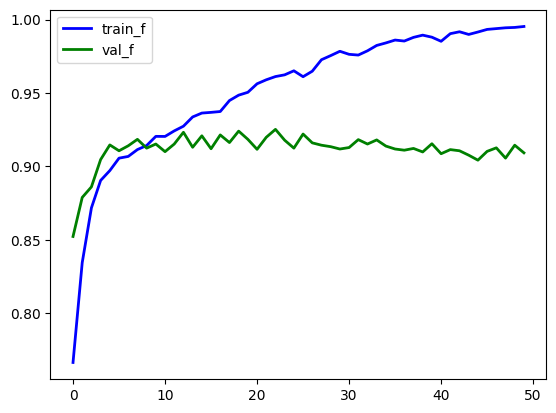

In [15]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd

# Data
df = pd.DataFrame({'epochs': range(0,len(train_f)), 
                  'train_f': train_f, 
                   'val_f': dev_f})
 
# multiple line plot
plt.plot('epochs', 'train_f', data=df, color='blue', linewidth=2)
plt.plot('epochs', 'val_f', data=df, color='green', linewidth=2)
plt.legend()
plt.show()


In [16]:
%load_ext tensorboard

In [17]:
tagger = torch.load(OUTPUT_PATH)
tagger.eval()

BiLSTMTagger(
  (embeddings): Embedding(30522, 768)
  (lstm): LSTM(768, 256, bidirectional=True)
  (dropout_layer): Dropout(p=0.5, inplace=False)
  (hidden2tag): Linear(in_features=512, out_features=6, bias=True)
)

In [18]:
labels = label_field.vocab.itos[2:]
labels = sorted(labels, key=lambda x: x.split("-")[-1])
label_idxs = [label_field.vocab.stoi[l] for l in labels]

test(tagger, test_iter, BATCH_SIZE, labels = label_idxs, target_names = labels)

              precision    recall  f1-score   support

        B-AC       0.78      0.29      0.43       270
        I-LF       0.56      0.41      0.47       288
        B-LF       0.35      0.15      0.21       150
         B-O       0.90      0.98      0.94      4292

    accuracy                           0.88      5000
   macro avg       0.65      0.46      0.51      5000
weighted avg       0.86      0.88      0.86      5000



In [19]:
from colorama import Back, Style

def vizu(words, output, truth):
    if isinstance(output, torch.Tensor):
        output = output.squeeze().tolist()
    col = {0: Back.BLACK, 1: Back.RED, 2: Back.GREEN, 3: Back.BLUE, 4: Back.MAGENTA}
    colors1 = [col[i] for i in output]
    colors2 = [col[i] for i in truth]
    words = [word.replace("Ġ", "") for word in words]
    print(Style.RESET_ALL + "Output:")
    for i, word in enumerate(words):
        print(colors1[i] + word, end=" ")
    print(Style.RESET_ALL + "\nTruth:")
    for i, word in enumerate(words):
        print(colors2[i] + word, end=" ")